## Top

In [29]:
import matplotlib
import pylab as plt
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import speclite.filters
import os
from astrometry.util.fits import fits_table
from collections import Counter
from datetime import datetime
from astrometry.util.starutil_numpy import datetomjd

In [2]:
### Try to verify actual CFHT depths using the same machinery, compare against CFHT's ETC on the web site (diet.py)

# diet.py assumes pixscale = 0.187


In [44]:
# Seeing and effective telescope diameters

seeings = {
    'CFHT': 0.8,
    'DECam': 1.2,
}

tel_diams = {
    'CFHT': 3.196 * u.m, # CFHT web page: effective area after obstructions = 80,216 cm^2 - https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/specsinformation.html
    'DECam': 3.51 * u.m, # DECam ETC spreadsheet, 9.70 sq m
}

In [45]:
pixscales = {
    #'CFHT'   : 0.185,
    'CFHT'   : 0.187,
    'DECam'  : 0.262,
}

# Number of pixels in the camera
cam_pix = {
    'CFHT':    40 * 2048 * 4612,
    'DECam':   60 * 2048 * 4096,
}

# Effective area per exposure, in square degrees
cam_sqdeg = {}
for k,v in cam_pix.items():
    cam_sqdeg[k] = v * (pixscales[k]/3600.)**2
cam_sqdeg

{'CFHT': 1.0194301029135804, 'DECam': 2.6658685534814817}

In [46]:
# Assumed galaxy size (Gaussian sigma), in arcsec
gal_size = 0.15 # arcsec

# Target S/N of source detection
snr = 5.

In [47]:
# Another "magic number" is the correction we apply to the LSST model sky spectrum.
# Search for "sky_scale" below.

In [48]:
# Now define a few functions for reading data files...

In [49]:
def read_lsst_throughput(fn, basedir='lsst-throughputs-1.9', wave_factor = 10.,
                        assert_2_words=True):
    fullfn = os.path.join(basedir, fn)
    vals = []
    for line in open(fullfn).readlines():
        line = line.strip()
        if line.startswith('#'):
            continue
        words = line.split()
        if len(words) == 0:
            continue
        if assert_2_words:
            assert(len(words) == 2)
        vals.append((float(words[0]), float(words[1])))
    vals = np.array(vals)
    # Bizarro subaru m1 file is not sorted!!
    I = np.argsort(vals[:,0])
    vals = vals[I,:]
    # Wavelength (nm->A), throughput
    return vals[:,0] * wave_factor, vals[:,1]

In [50]:
def read_uves_spectrum(fn):
    hdu = fits.open(fn)[0]
    hdr = hdu.header
    sky_flux = hdu.data
    crpix, crval, cdelt = hdr['CRPIX1'], hdr['CRVAL1'], hdr['CDELT1']
    sky_pix = (1 + np.arange(len(sky_flux)))
    sky_wave = crval + (sky_pix - crpix) * cdelt
    return sky_wave, sky_flux

In [51]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [52]:
# First up, read the dark sky model.  We have three available:
# - UVES - from https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html
#               https://ui.adsabs.harvard.edu/abs/2003A%26A...407.1157H/abstract
# - DESI - used for DESI sims
#          https://desi.lbl.gov/trac/browser/code/desimodel/trunk/data/spectra/spec-sky.dat
# - LSST - estimated for predictions; version 1.9 of
#          https://github.com/lsst/throughputs/blob/1.9/baseline/darksky.dat

In [53]:
# the UVES spectra are split into pieces... join them together
wave1,flux1 = read_uves_spectrum('fluxed_sky_346.fits')
wave2,flux2 = read_uves_spectrum('fluxed_sky_437.fits')
wave3,flux3 = read_uves_spectrum('fluxed_sky_580L.fits')
split12 = 3760.
split23 = 4850.
I1 = (wave1 < split12)
I2 = (wave2 >= split12) * (wave2 < split23)
I3 = (wave3 >= split23)
sky_wave = np.hstack((wave1[I1], wave2[I2], wave3[I3]))
sky_flux = np.hstack((flux1[I1], flux2[I2], flux3[I3]))
# The UVES sky fluxes are in 1e-16 erg/(s A cm^2 arcsec^2)
uves_sky_wave = sky_wave * u.Angstrom
# per arcsec^2
uves_sky_flux = sky_flux * 1e-16 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [54]:
# Next, a spectrum used for DESI sims.
#desi_sky = read_table('spec-sky.dat', sky_wave_u, wave_scale=1., trans_scale=1.)
desi_sky = read_table('spec-sky-cut.dat', None, wave_scale=1., trans_scale=1.)
desi_sky_wave = desi_sky[:,0] * u.Angstrom
desi_sky_flux = desi_sky[:,1] * 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [55]:
# Finally, the dark sky model from the LSST throughputs repo
w,f = read_lsst_throughput('darksky.dat')
# is in "Flambda(ergs/cm^s/s/nm)"
f *= 0.1 # -> to ergs/cm^2/s/A
lsst_sky_wave = w * u.Angstrom
lsst_sky_flux = f * u.erg / (u.cm**2 * u.s * u.Angstrom)
#lsst_sky = interp1d(w,f)
#lsst_sky = interp1d(wavegrid, lsst_sky, bounds_error=False, fill_value=0.)
#lsst_sky_u = lsst_sky(sky_wave_u) * sky_flux_u.unit

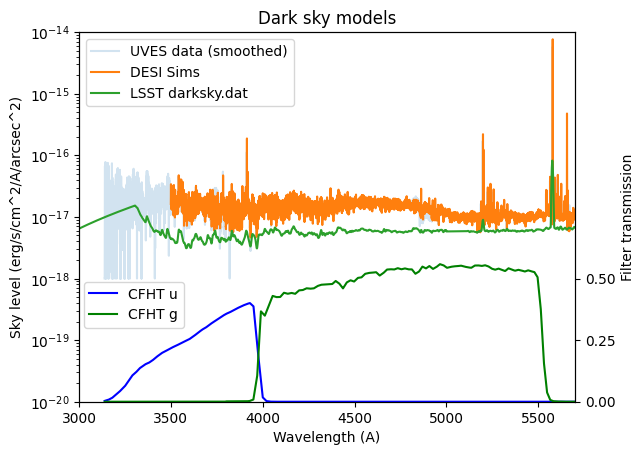

In [56]:
filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g')

uves2 = gaussian_filter(uves_sky_flux, 5.)
plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves2),  label='UVES data (smoothed)', alpha=0.2);
#plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves_sky_flux.value),  label='UVES data', alpha=0.2);
plt.semilogy(desi_sky_wave, desi_sky_flux, label='DESI Sims');
plt.semilogy(lsst_sky_wave, lsst_sky_flux, label='LSST darksky.dat');
plt.legend()
plt.ylim(1e-20, 1e-14);
plt.xlabel('Wavelength (A)')
plt.ylabel('Sky level (erg/s/cm^2/A/arcsec^2)')
plt.xlim(3000, 5700)

# Also plot the u,g filters
plt.twinx()
plt.plot(uves_sky_wave, filters[0].interpolator(uves_sky_wave), 'b', label='CFHT u')
plt.plot(uves_sky_wave, filters[1].interpolator(uves_sky_wave), 'g', label='CFHT g')
plt.ylim(0,1.5)
plt.ylabel('Filter transmission')
plt.yticks([0., 0.25, 0.5])
plt.legend(loc=(0.01, 0.2))#'lower left')

plt.title('Dark sky models')
plt.savefig('sky.png')

In [57]:
# ... from which we can see that the LSST model is considerably more optimistic...

In [58]:
filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g', 'bessell-U', 'bessell-B', 'cfht_megacam-u', 'cfht_megacam-g')

print('UVES sky model:')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(uves_sky_flux, uves_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(desi_sky_flux, desi_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('LSST sky model:')
for f in filters:
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(lsst_sky_flux, lsst_sky_wave))    

UVES sky model:
Filter     decam2014-u : sky is 21.82 mag / arcsec^2
Filter     decam2014-g : sky is 21.40 mag / arcsec^2
Filter       bessell-U : sky is 21.79 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 21.78 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated
Filter     decam2014-u : sky is 21.85 mag / arcsec^2
Filter     decam2014-g : sky is 21.39 mag / arcsec^2
Filter       bessell-U : sky is 22.21 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 22.08 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

LSST sky model:
Filter     decam2014-u : sky is 22.85 mag / arcsec^2
Filter     decam2014-g : sky is 22.23 mag / arcsec^2
Filter       bessell-U : sky is 22.90 mag / arcsec^2
Filter       bessell-B : sky is 22.49 mag / arcsec^2
Filter  cfht_megac

In [59]:
# Which one should we use?
# This paper
#   https://ui.adsabs.harvard.edu/abs/2007PASP..119..687K/abstract
# gives CTIO average measurements of U ~ 22.12 and B ~ 22.82 (Table 6)

# The Dark Energy Survey DR1
#   https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A/abstract
# reports a median g ~ 22.01

# This web page
#   https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/quickinformation.html
# reports CFHT Megacam u ~ 22.70, g ~ 22.00 at zenith, 0% moon

In [72]:
# empirical correction factor to get the g-band sky counts in e/sec/pixel to match diet.py!
-2.5 * np.log10(4.86 / 3.34)


-0.4072245061268225

In [73]:
0.29 - 0.41

-0.12

In [74]:
# I am therefore going to take the LSST sky model but scale it to be XX mag brighter!
#brighten = 0.29
brighten = -0.12

sky_scaling = 10.**((-brighten) / -2.5)
sky_scaling

I = np.flatnonzero(lsst_sky_wave.value < 6000)
sky_wave = lsst_sky_wave[I]
sky_flux = lsst_sky_flux[I] * sky_scaling

print('Brightened LSST sky model:')
for f in filters:
    if 'bessell' in f.name:
        continue
    pf,pw = f.pad_spectrum(sky_flux, sky_wave, method='zero')   
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(pf, pw))

Brightened LSST sky model:
Filter     decam2014-u : sky is 23.17 mag / arcsec^2
Filter     decam2014-g : sky is 22.38 mag / arcsec^2
Filter  cfht_megacam-u : sky is 23.09 mag / arcsec^2
Filter  cfht_megacam-g : sky is 22.40 mag / arcsec^2


In [75]:
# (NOTE that the values printed above are for the Speclite CFHT filter definitions -- below, we'll use CFHT documents instead.)


In [76]:
# Next up, we try to figure out transmission curves for each telescope under consideration.
# In general, we're doing this by referring to information produced by each observatory.
# For comparison, we have 'speclite' filter curves for some combinations.

In [77]:
wavegrid = sky_wave

In [78]:
# CFHT:
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/QE_camera.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Optics_TR.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Al_coating.dat
# https://www.cfht.hawaii.edu/Instruments/Filters/curves/cfh9302.dat
# from https://www.cfht.hawaii.edu/Instruments/Filters/megaprime.html

# CCD QE
qe = read_table('cfht/QE_camera.dat', sky_wave)
# Optics_TR.dat
optics = read_table('cfht/Optics_TR.dat', sky_wave)
# Mirror - Al_coating.dat
mirror = read_table('cfht/Al_coating.dat', sky_wave)

cfht_thru = interp1d(sky_wave, qe * optics * mirror)

# Filters - 
cfht_u_filt    = interp1d(sky_wave, read_table('cfht/cfh9302.dat', sky_wave, sep=','))
cfht_g_filt    = interp1d(sky_wave, read_table('cfht/cfh9402.dat', sky_wave, sep=','))
cfht_cahk_filt = interp1d(sky_wave, read_table('cfht/cfh9303.dat', sky_wave, sep=','))

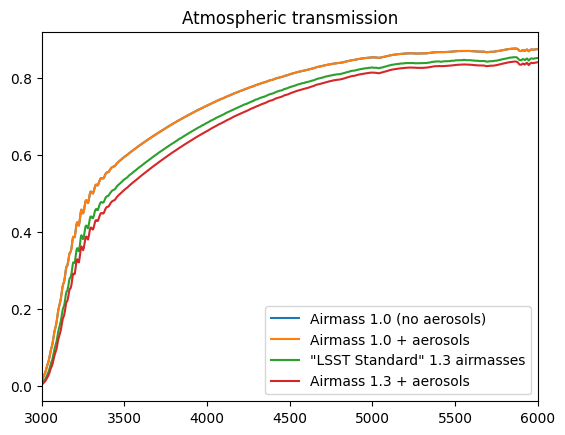

In [79]:
# Another big choice we have is the atmospheric transmission model.  The LSST sims have a variety of models,
# at different airmasses, and with/without aerosols.  These make quite a big difference!
atm = interp1d(*read_lsst_throughput('atmos_std.dat'))
atm10 = interp1d(*read_lsst_throughput('atmos_10.dat'))
basedir = 'lsst-throughputs-1.9/'
atm10_noaero = interp1d(*read_lsst_throughput('atmos_10.dat', basedir=basedir)) #'/Users/dstn/lsst-throughputs/atmos'))
#atm12_hi = interp1d(*read_lsst_throughput('atmos_12_hiwater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo = interp1d(*read_lsst_throughput('atmos_12_lowater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
# Water doesn't make a difference for us in the blue -- but aerosols do!
#atm12_hi_a = interp1d(*read_lsst_throughput('atmos_12_hiwater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo_a = interp1d(*read_lsst_throughput('atmos_12_lowater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm13_a = interp1d(*read_lsst_throughput('atmos_13_aerosol.dat', basedir=basedir))
wave = sky_wave
plt.plot(wave, atm10_noaero(wave), label='Airmass 1.0 (no aerosols)')
plt.plot(wave, atm10(wave), label='Airmass 1.0 + aerosols')
plt.plot(wave, atm(wave), label='"LSST Standard" 1.3 airmasses')
plt.plot(wave, atm13_a(wave), label='Airmass 1.3 + aerosols')
plt.xlim(3000, 6000)
plt.title('Atmospheric transmission')
plt.legend();

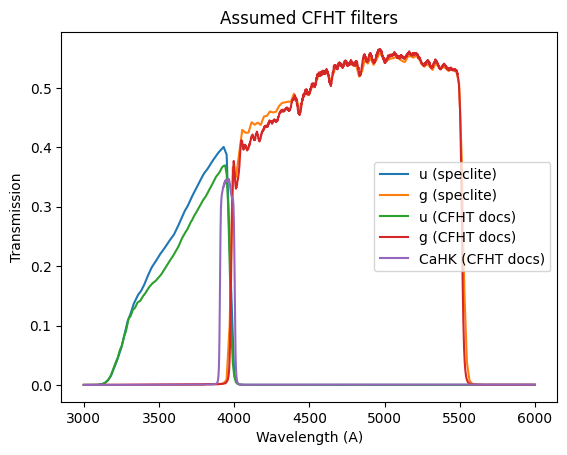

In [93]:
cfht_filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g')

# Note that the speclite version includes 1.25 Airmasses of atmospheric attenuation.

#cfht_atm = atm
# Let's use the 1.0 airmass version!
cfht_atm = atm10

atmo = cfht_atm(sky_wave)
thru = cfht_thru(sky_wave)
#speclite.filters.plot_filters(cfht_filters)
plt.plot(sky_wave, cfht_filters[0].interpolator(sky_wave), label='u (speclite)');
plt.plot(sky_wave, cfht_filters[1].interpolator(sky_wave), label='g (speclite)');
plt.plot(sky_wave, thru * cfht_u_filt(sky_wave)    * atmo, label='u (CFHT docs)');
plt.plot(sky_wave, thru * cfht_g_filt(sky_wave)    * atmo, label='g (CFHT docs)');
plt.plot(sky_wave, thru * cfht_cahk_filt(sky_wave) * atmo, label='CaHK (CFHT docs)');

plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.title('Assumed CFHT filters')
plt.legend();

In [94]:
combos = []

def thrufunc(w,tel,atm,filt):
    f = interp1d(wavegrid, tel(wavegrid)*atm(wavegrid)*filt(wavegrid), bounds_error=False, fill_value=0.)
    return f
def skythrufunc(w,tel,filt):
    f = interp1d(wavegrid, tel(wavegrid)*filt(wavegrid), bounds_error=False, fill_value=0.)
    return f

# We're using the versions from the CFHT docs
combos.append(('CFHT', 'CaHK',
               thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_cahk_filt),
               skythrufunc(wavegrid, cfht_thru, cfht_cahk_filt)))
combos.append(('CFHT', 'u',
               thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_u_filt),
               skythrufunc(wavegrid, cfht_thru, cfht_u_filt)))
combos.append(('CFHT', 'g',
               thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_g_filt),
               skythrufunc(wavegrid, cfht_thru, cfht_g_filt)))

In [95]:
# Define AB reference source flux
ref_mag = 20.
ref = speclite.filters.ab_reference_flux(sky_wave, magnitude=ref_mag)

In [96]:
tel_areas = {}
for k,diam in tel_diams.items():
    tel_areas[k] = (np.pi * (diam / 2.)**2).to('cm^2')
tel_areas

{'CFHT': <Quantity 80223.83566578 cm2>, 'DECam': <Quantity 96761.83912873 cm2>}

In [97]:
# Energy of a photon of wavelength sky_wave_u
wave_ergs = (const.h.cgs * const.c.cgs / sky_wave).to('erg')
dwave = np.diff(sky_wave)
dwave = np.append(dwave, [dwave[-1]])

tel_area = tel_areas['CFHT']
ref_photon_rate = ref      * dwave * tel_area / wave_ergs
sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs

# HACK - CFHT gain from diet.py
#gains = dict(CFHT = 1.6)
# HACK - gain value from Jean-Charles
gains = dict(CFHT = 1.5)

for tel,band,thru_src,thru_sky in combos:
    if tel != 'CFHT':
        continue
    sky_photons = np.sum(sky_photon_rate * thru_sky(sky_wave))
    sky_photons_perpix = sky_photons * pixscales[tel]**2
    print('%10s %8s: sky count rate is %.2f photons/pixel/sec' % (tel, band, sky_photons_perpix.value))
    gain = gains[tel]
    print('                           %.3f ADU/pixel/sec' % (sky_photons_perpix.value / gain))
print()
print()

for tel,band,thru_src,thru_sky in combos:
    ref_photons = np.sum(ref_photon_rate * thru_sky(sky_wave))
    sky_photons = np.sum(sky_photon_rate * thru_sky(sky_wave))
    sky_mag = ref_mag -2.5 * np.log10(sky_photons / ref_photons)
    print('%10s %8s: sky brightness is %.2f mag/arcsec^2' % (tel, band, sky_mag))

      CFHT     CaHK: sky count rate is 0.11 photons/pixel/sec
                           0.075 ADU/pixel/sec
      CFHT        u: sky count rate is 0.69 photons/pixel/sec
                           0.460 ADU/pixel/sec
      CFHT        g: sky count rate is 3.33 photons/pixel/sec
                           2.222 ADU/pixel/sec


      CFHT     CaHK: sky brightness is 23.03 mag/arcsec^2
      CFHT        u: sky brightness is 23.05 mag/arcsec^2
      CFHT        g: sky brightness is 22.41 mag/arcsec^2


In [98]:
# Define an AB source of 25th mag
src_mag = 25.
src = speclite.filters.ab_reference_flux(sky_wave, magnitude=src_mag)

In [110]:
src

<Quantity [1.20949602e-18, 1.20869009e-18, 1.20788497e-18, ...,
           3.02676605e-19, 3.02575688e-19, 3.02474821e-19] erg / (Angstrom s cm2)>

In [135]:
def moffat(seeing, pixscale):
    n = 20
    xx,yy = np.meshgrid(np.arange(-n, n+1), np.arange(-n, n+1))
    beta = 3.
    # seeing is FWHM; compute alpha=HWHM, and convert to pixels.
    alpha = seeing / 2. / pixscale
    # correction factor to make fwhm work out
    fac = 2.**(1./beta)-1.
    moff = (1. + fac*(xx**2 + yy**2)/alpha**2)**(-beta)
    moff /= np.sum(moff)
    return moff

In [140]:
def moffat_nea_pix(seeing, pixscale):
    moff = moffat(seeing, pixscale)
    nea = 1. / np.sum(moff**2)
    return nea

In [143]:
def gaussian_nea_pix(seeing, pixscale):
    see_pix = seeing / pixscale
    sig_pix = see_pix / 2.35
    nea = 4. * np.pi * sig_pix**2
    return nea

In [144]:
moffat_nea_pix(0.8, 0.187), gaussian_nea_pix(0.8, 0.187)

(68.97201343592481, 41.64577039367181)

In [149]:
from scipy.optimize import brentq

In [165]:
print()
print('For an AB reference source with mag = %g, at S/N = %g' % (src_mag, snr))
psf_exp_times = []
gal_exp_times = []
for tel,band,thru_src,thru_sky in combos:
    print()
    print(tel, band)
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]

    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    #print('Telescope area for', tel, '=', tel_area)
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru_sky(sky_wave))
    # Total photon count
    src_photon_rate = src * dwave * tel_area / wave_ergs

    # HACK -- empirical correction factor to diet.py -- essentially another throughput factor
    src_photon_rate *= 0.9723
    
    src_photon_rate = np.sum(src_photon_rate * thru_src(sky_wave))
    # Noise-equivalent area for the source
    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    #print('PSF sigma: %.3f arcsec' % sig)
    #nea_psf = 4.*np.pi * sig**2 # arcsec^2
    #print('NEA for PSF: %.3f arcsec^2' % nea_psf)
    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    #nea_psf_pix = nea_psf / (pixel_size**2) # in pixels
    #print('NEA for PSF: %.3f pixels' % nea_psf_pix)
    #nea_psf_pix = gaussian_nea_pix(seeing, pixel_size)
    nea_psf_pix = moffat_nea_pix(seeing, pixel_size)
    
    print('Noise-equivalent area for PSF: %.2f pixels' % nea_psf_pix)
    print('Sky photon rate: %.3f e-/sec/pixel' % sky_photon_rate.value)
    print('Source photon rate: %.3f e-/sec' % src_photon_rate.value)

    # Required exposure times
    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2

    def obj(t):
        nccd = 5.
        nccd_adu = nccd / gain
        stot_adu = sky_photon_rate.value * t / gain
        # this pretty much has to be a bug, the units don't make sense
        s2 = stot_adu / gain + nccd_adu**2

        bg_photons = s2 * gain**2 * nea_psf_pix
        src_photons = src_photon_rate.value * t
        sn = src_photons / np.sqrt(bg_photons)
        # "snr" is a global target SNR
        #print('sn:', sn)
        return sn - snr
    
    t_psf_2 = brentq(obj, 1., t_psf.value*2)
    #print('t_psf:', t_psf, 'to', t_psf_2)
    t_psf = t_psf_2 * t_psf.unit
    
    gal_exp_times.append(t_galaxy)
    psf_exp_times.append(t_psf)

    print('PSF: Total sky photons per pixel: %.3f' % (sky_photon_rate * t_psf))

    print('PSF: Total sky ADU per pixel: %.3f' % (sky_photon_rate * t_psf / gain))
    
    print('PSF: Total sky photons per pixel * NEA: %.3f' % (sky_photon_rate * t_psf * nea_psf_pix))
    print('PSF: sqrt(Total sky photons per pixel * NEA): %.3f' % (np.sqrt(sky_photon_rate * t_psf * nea_psf_pix)))
    print('PSF: Total source photons: %.3f' % (src_photon_rate * t_psf))

    print('%10s %8s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, band, t_galaxy.value, t_psf.value))



For an AB reference source with mag = 25, at S/N = 5

CFHT CaHK
Noise-equivalent area for PSF: 68.97 pixels
Sky photon rate: 0.113 e-/sec/pixel
Source photon rate: 0.367 e-/sec
PSF: Total sky photons per pixel: 185.252
PSF: Total sky ADU per pixel: 123.502
PSF: Total sky photons per pixel * NEA: 12777.221
PSF: sqrt(Total sky photons per pixel * NEA): 113.036
PSF: Total source photons: 602.111
      CFHT     CaHK: Exp time for Galaxy:  1062.8 sec, PSF:  1638.5 sec

CFHT u
Noise-equivalent area for PSF: 68.97 pixels
Sky photon rate: 0.690 e-/sec/pixel
Source photon rate: 1.999 e-/sec
PSF: Total sky photons per pixel: 228.015
PSF: Total sky ADU per pixel: 152.010
PSF: Total sky photons per pixel * NEA: 15726.664
PSF: sqrt(Total sky photons per pixel * NEA): 125.406
PSF: Total source photons: 660.510
      CFHT        u: Exp time for Galaxy:   219.2 sec, PSF:   330.4 sec

CFHT g
Noise-equivalent area for PSF: 68.97 pixels
Sky photon rate: 3.333 e-/sec/pixel
Source photon rate: 6.982 e-/se

## Compare to diet.py

In [88]:
import diet

In [100]:
mag = 25.0
airmass = 1.0
seeing = 0.8
#gain=diet.mp_config['gain']
gain = 1.5

tt = diet.psfexptime(snr=5.0,
                     filter='g',
                     mAB=mag,
                     fluxormag='mag',
                     background='dark',
                     am=airmass,
                     trans=1.0,
                     gain=gain,
                     seeing=seeing)

sky (including airmass term): 3.34
Aperture photom exposure time: 165.7715414665623
zeropoint: 27.110
zeropoint with airmass: 27.110
gain: 1.500
signal / second [ADU]: 4.655
signal / second [e-]:  6.982
sky / second [ADU]: 2.227
sky / second [e-] : 3.340


In [92]:
tt = tt()
print('Exptime', tt)

t_exp 55.2571804888541 Ftot_ADU: 257.2156931683916 sig2flux: 81.78809909980424 -> SNR 3.1449036717984713
t_exp 497.31462439968686 Ftot_ADU: 2314.9412385155247 sig2flux: 232.7652801695869 -> SNR 9.945388920671146
t_exp 175.84550779815623 Ftot_ADU: 818.540211040517 sig2flux: 140.1575393414645 -> SNR 5.8401439900162275
t_exp 138.25644467445943 Ftot_ADU: 643.567531628068 sig2flux: 124.92369673734622 -> SNR 5.151684975999209
t_exp 130.60061262439635 Ftot_ADU: 607.9305315112239 sig2flux: 121.58725839427694 -> SNR 4.999952622830411
t_exp 130.60300309449588 Ftot_ADU: 607.9416588691204 sig2flux: 121.58831445841324 -> SNR 5.00000071205078
t_exp 130.60296769911858 Ftot_ADU: 607.9414941077912 sig2flux: 121.58829882147693 -> SNR 5.000000000003344
t_exp 130.60296769895234 Ftot_ADU: 607.9414941070173 sig2flux: 121.58829882140347 -> SNR 5.0
Exptime 130.60296769895234


## Parse log file from Jean-Charles

In [3]:
lines = open('MegaCam-2023.g.qso-elx.log').readlines()

In [11]:
T = fits_table()
T.expnum = []
T.obsdate = []
T.ra = []
T.dec = []
T.exptime = []
T.filter = []
T.airmass = []
T.seeing_center = []
T.seeing_outer = []
T.skylevel = []
T.photometric = []

for line in lines:
    words = line.split('|')
    words = [w.strip() for w in words]
    T.expnum.append(int(words[0]))
    w = words[1].split()
    T.obsdate.append(' '.join(w[1:]))
    w = words[3].split()
    T.ra.append(w[0])
    T.dec.append(w[1])
    T.exptime.append(int(words[4]))
    T.filter.append(words[5])
    T.airmass.append(float(words[6]))
    w = words[7].split()
    T.seeing_center.append(float(w[0]))
    T.seeing_outer.append(float(w[1]))
    T.skylevel.append(float(w[2]))
    w = words[8].split()
    T.photometric.append(w[0])
T.to_np_arrays()
T.about()

tabledata object with 4119 rows and 11 columns:
   airmass (<class 'numpy.ndarray'>) shape (4119,) dtype float64
   dec (<class 'numpy.ndarray'>) shape (4119,) dtype <U9
   expnum (<class 'numpy.ndarray'>) shape (4119,) dtype int64
   exptime (<class 'numpy.ndarray'>) shape (4119,) dtype int64
   filter (<class 'numpy.ndarray'>) shape (4119,) dtype <U1
   obsdate (<class 'numpy.ndarray'>) shape (4119,) dtype <U18
   photometric (<class 'numpy.ndarray'>) shape (4119,) dtype <U1
   ra (<class 'numpy.ndarray'>) shape (4119,) dtype <U10
   seeing_center (<class 'numpy.ndarray'>) shape (4119,) dtype float64
   seeing_outer (<class 'numpy.ndarray'>) shape (4119,) dtype float64
   skylevel (<class 'numpy.ndarray'>) shape (4119,) dtype float64


In [17]:
Counter(T.filter)

Counter({'g': 4119})

In [26]:
T.obsdate

array(['Feb 23 21:19:42 23', 'Feb 23 21:25:25 23', 'Feb 23 21:31:07 23',
       ..., 'Oct 18 05:05:27 23', 'Oct 18 05:11:11 23',
       'Oct 18 05:20:53 23'], dtype='<U18')

In [30]:
Counter([len(t) for t in T.obsdate])

Counter({18: 4119})

In [33]:
# HACK -- this is HAWAII time, not UTC!!!
T.date = np.array([datetime.strptime(t, '%b %d %H:%M:%S %y') for t in T.obsdate])
T.mjd = np.array([datetomjd(d) for d in T.date])

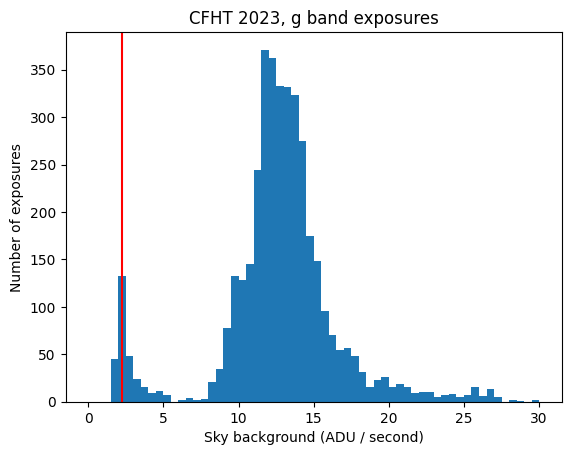

In [43]:
plt.hist(T.skylevel / T.exptime, range=(0, 30), bins=60);
plt.xlabel('Sky background (ADU / second)')
plt.ylabel('Number of exposures');
plt.title('CFHT 2023, g band exposures');
# From diet.py, and J-C's gain=1.5 number
plt.axvline(3.34 / 1.5, color='r')
plt.savefig('sky-adu.png')

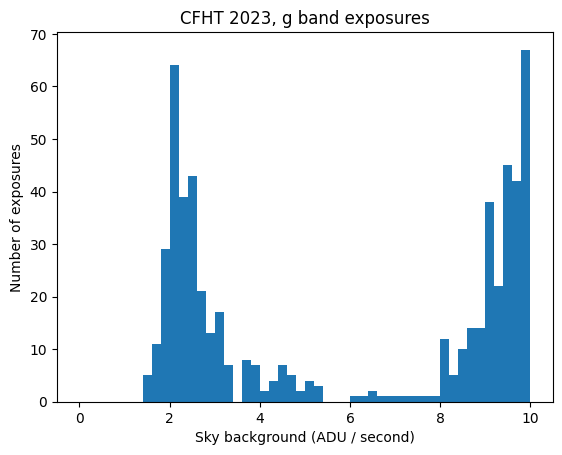

In [40]:
plt.hist(T.skylevel / T.exptime, range=(0, 10), bins=50);
plt.xlabel('Sky background (ADU / second)')
plt.ylabel('Number of exposures');
plt.title('CFHT 2023, g band exposures');
plt.savefig('sky-adu-2.png')

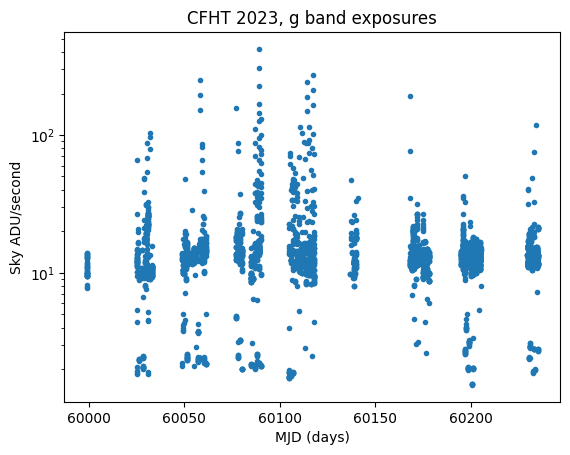

In [36]:
plt.plot(T.mjd, T.skylevel / T.exptime, '.');
plt.title('CFHT 2023, g band exposures');
plt.xlabel('MJD (days)')
plt.ylabel('Sky ADU/second');
plt.yscale('log')

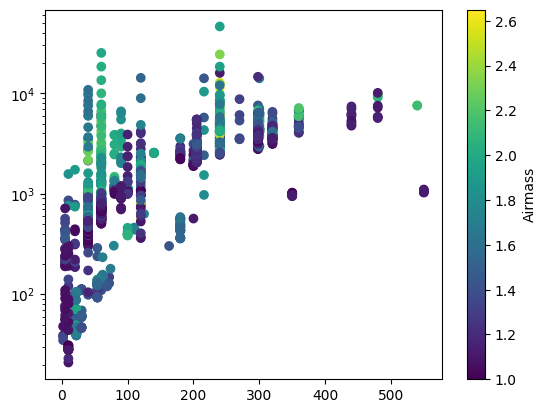

In [23]:
plt.scatter(T.exptime, T.skylevel, c=T.airmass);
cb = plt.colorbar()
cb.set_label('Airmass')
plt.yscale('log');

In [6]:
lines[0]

'2847500 | 23AQ03 Feb 23 21:19:42 23 | P34 JF1        |  7:57:47.3  21:25:04 2000 |  298 | g | 1.02 | 0.71 0.70  3494 |A 3 O D|\n'

## Parse headers fetched from CADC

In [187]:
from astropy.table import Table
import os
from glob import glob
import fitsio

In [257]:
# A query for data in CADC, megaprime, g band, COSMOS.
t = Table.read('result_alnv8twr9vl7bo9r.csv')

In [178]:
product_id = t['"Product ID"']

In [183]:
# "pip install cadcdata"
# to get "cadcget".
# For whatever reason, 'os.system()' of this command didn't seem to work, I just copy-n-pasted the commands to a terminal.
for p in product_id:
    prod = 'CFHT/%s.fits.fz' % p
    outfn = '/pscratch/sd/d/dstn/%s.head.fits' % p
    if not os.path.exists(outfn):
        cmd = 'cadcget --fhead -o %s %s' % (outfn, prod)
        print(cmd)
    #rtn = os.system(cmd)
    #print(rtn)

cadcget --fhead -o /pscratch/sd/d/dstn/1910028p.head.fits CFHT/1910028p.fits.fz
cadcget --fhead -o /pscratch/sd/d/dstn/2235439p.head.fits CFHT/2235439p.fits.fz
cadcget --fhead -o /pscratch/sd/d/dstn/2246098p.head.fits CFHT/2246098p.fits.fz


In [240]:
hdrvals = []
tmpfn = '/tmp/head.fits'
fns = glob('/pscratch/sd/d/dstn/*.head.fits')
fns.sort()
for fn in fns:
#for fn in glob('/pscratch/sd/d/dstn/3147172p.head.fits'):
    f = open(fn, 'rb')
    txt = f.read()
    i = txt.index(b"XTENSION= 'BINTABLE'")
    txt = txt[:i]
    out = []
    while len(txt):
        out.append(txt[:80])
        txt = txt[81:]
    out = b''.join(out)
    l = len(out)
    #print('header length:', l)
    pad = l % 2880
    if pad > 0:
        pad = 2880 - pad
    out = out + b' '*pad
    open(tmpfn, 'wb').write(out)

    hdr = fitsio.read_header(tmpfn)
    #print('header:', hdr)
    H = ['AIRMASS', 'MOONALT', 'PHOT_C', 'QSOGRADE', 'IQMEASUR', 'BGMEASUR', 'MOONPHAS']
    good = True
    for h in H:
        if not h in hdr:
            print(fn, 'missing', h)
            good = False
            break
    if not good:
        continue
    hdrvals.append([hdr[h] for h in H])

/pscratch/sd/d/dstn/1795464p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1805915p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1851011p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1851199p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1861432p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1894475p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1909582p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1909756p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1910028p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1916300p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1917040p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1925299p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/1936395p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/2068035p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/2068272p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/2068894p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/2069590p.head.fits missing QSOGRADE
/pscratch/sd/d/dstn/2069854p.head.fits missing Q

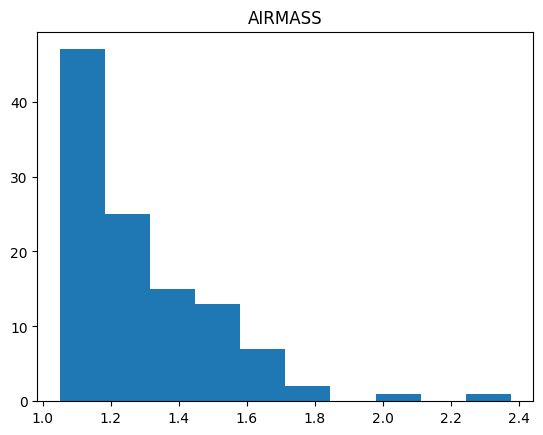

In [241]:
plt.hist([h[0] for h in hdrvals])
plt.title(H[0]);

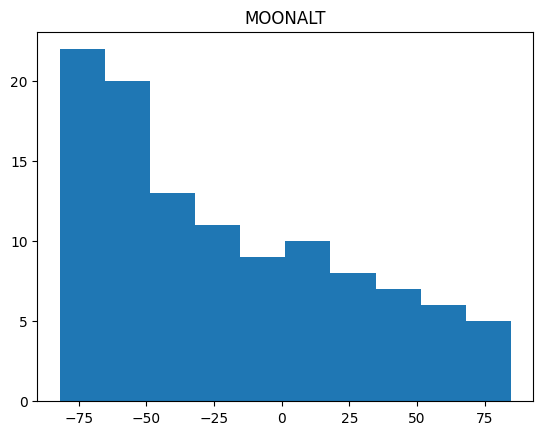

In [242]:
plt.hist([h[1] for h in hdrvals])
plt.title(H[1]);

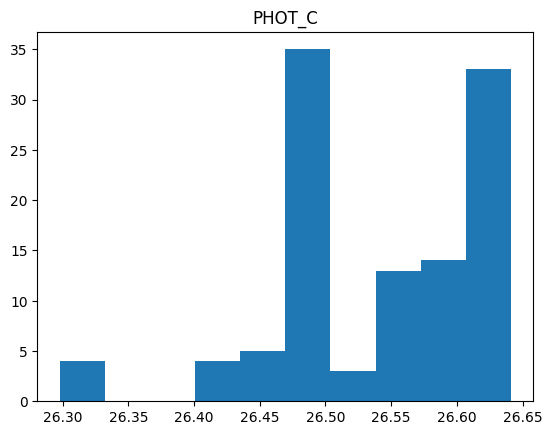

In [243]:
plt.hist([h[2] for h in hdrvals])
plt.title(H[2]);

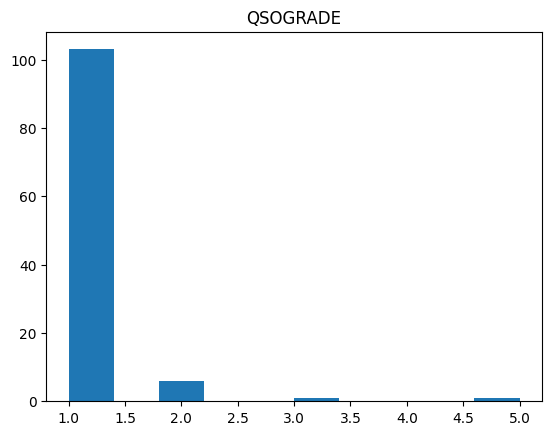

In [244]:
plt.hist([h[3] for h in hdrvals])
plt.title(H[3]);

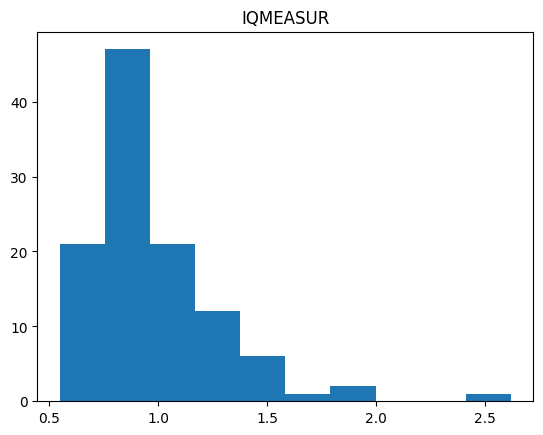

In [245]:
plt.hist([h[4] for h in hdrvals])
plt.title(H[4]);

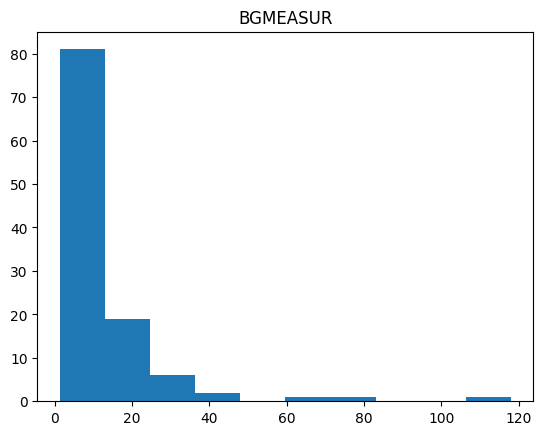

In [246]:
plt.hist([h[5] for h in hdrvals])
plt.title(H[5]);

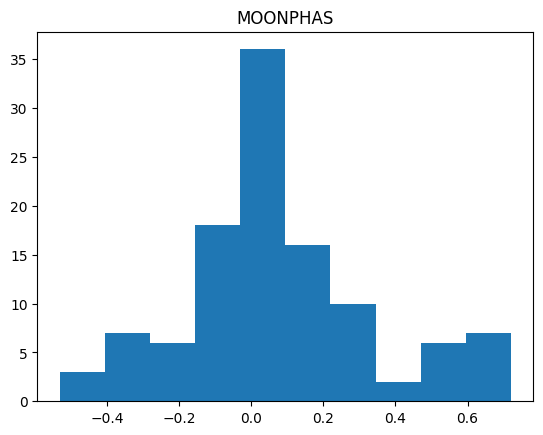

In [247]:
plt.hist([h[6] for h in hdrvals])
plt.title(H[6]);

In [248]:
bg = np.array([h[5] for h in hdrvals])
moonalt = np.array([h[1] for h in hdrvals])
airmass = np.array([h[0] for h in hdrvals])
moonphase = np.array([h[6] for h in hdrvals])
qsograde = np.array([h[3] for h in hdrvals])
I = np.flatnonzero(qsograde == 1)

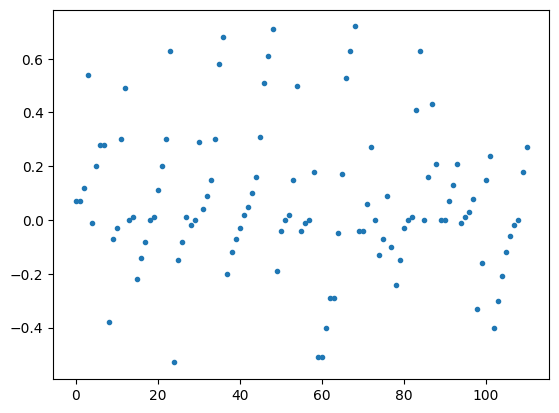

In [251]:
plt.plot(moonphase, '.');

In [238]:
len(I)

103

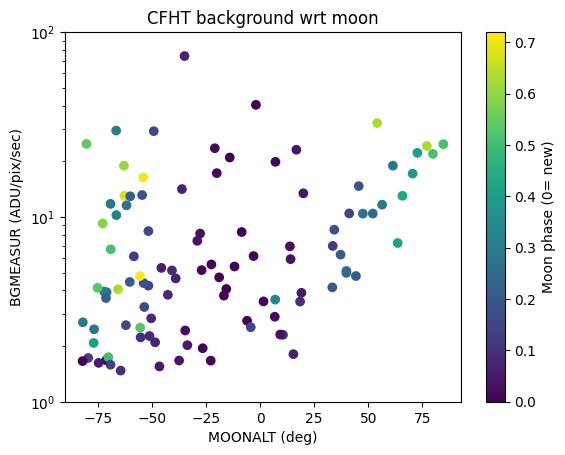

In [256]:
plt.scatter(moonalt[I], bg[I], c=np.abs(moonphase[I]));# cmap='RdBu'); #airmass[I]);
c = plt.colorbar()
plt.yscale('log')
plt.yticks([1, 10, 100])
c.set_label('Moon phase (0= new)')
plt.xlabel('MOONALT (deg)')
plt.ylabel('BGMEASUR (ADU/pix/sec)')
plt.title('CFHT background wrt moon')
plt.savefig('bgmoon.png')

In [258]:
pwd

'/global/u1/d/dstn/cfht-etc'

## line source
ref_photon_rate = ref * dwave * tel_area / wave_ergs
print('For a line source of 1e-16 erg/sec/cm^2 centered in the filter...')
print()
src_mags = {}
for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave))
    src_photon_rate = srcs[mbi] * dwave * tel_area / wave_ergs
    src_photons = np.sum(src_photon_rate * thru(sky_wave))
    src_mag = ref_mag -2.5 * np.log10(src_photons / ref_photons)

    src_photon_rate2 = srcs[mbi] * mb_line_fluxes[mbi] * dwave * tel_area / wave_ergs
    src_photons2 = np.sum(src_photon_rate2 * thru(sky_wave))
    src_mag2 = ref_mag -2.5 * np.log10(src_photons2 / ref_photons)
    
    src_mags[(tel,mbi)] = src_mag2

    print('%10s %8s: source brightness is %.2f mag      (flux %6.2f:  mag %.2f)' % (tel, mbnames[mbi], src_mag,
                                                                                  mb_line_fluxes[mbi], src_mag2))

In [383]:
overhead = 40.
n_exp = 3
tiling = 1.05

In [384]:
print('For %g square degrees... (line flux = 10^-16 erg/sec/cm^2)' % survey_area)
print()
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times):
    line_flux = mb_line_fluxes[mbi]
    fields = survey_area / cam_sqdeg[tel] * tiling
    psf_nights = (t_psf.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    gal_nights = (t_gal.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    print('%10s %8s (line flux %3.2f): %7.1f nights' % (tel, mbnames[mbi], line_flux, gal_nights))

For 1000 square degrees... (line flux = 10^-16 erg/sec/cm^2)

     DECam     CaHK (line flux 1.00):    56.3 nights
     DECam      MB1 (line flux 1.00):   141.3 nights
      CFHT     CaHK (line flux 1.00):    37.8 nights
      CFHT      MB1 (line flux 1.00):    90.3 nights
      CFHT     u(2) (line flux 1.00):   188.7 nights
      CFHT  CaHK(2) (line flux 1.00):    39.6 nights


In [359]:
print('For %g square degrees... (line fluxes in 10^-16 erg/sec/cm^2)' % survey_area)
print()
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times_2, gal_exp_times_2):
    line_flux = mb_line_fluxes[mbi]
    fields = survey_area / cam_sqdeg[tel] * tiling
    psf_nights = (t_psf.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    gal_nights = (t_gal.value + overhead * n_exp) * fields / 3600. / hrs_per_night
    print('%10s %8s (line flux %3.2f): %7.1f nights' % (tel, mbnames[mbi], line_flux, gal_nights))


For 1000 square degrees... (line fluxes in 10^-16 erg/sec/cm^2)

     DECam     CaHK (line flux 1.00):    56.3 nights
     DECam      MB1 (line flux 1.00):   141.3 nights
      CFHT     CaHK (line flux 1.00):    37.8 nights
      CFHT      MB1 (line flux 1.00):    90.3 nights
      CFHT     u(2) (line flux 1.00):   188.7 nights
      CFHT  CaHK(2) (line flux 1.00):    39.6 nights


In [319]:
#### IGNORE BELOW HERE

In [143]:
tele_order = ['CFHT', 'DECam']

print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of nights for various telescopes')
print()

print('          ', end='')
for t in tele_order:
    print('  & %8s' % t, end='')
print('  \\\\')

nights = {}
for ifilter in range(len(MB)):
    for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times_2):
        if mbi != ifilter:
            continue
        line_flux = mb_line_fluxes[mbi]
        fields = survey_area / cam_sqdeg[tel]
        f = fields / 3600. / hrs_per_night
        gal_nights = f * t_gal.value
        nights[(tel,mbi)] = gal_nights

    print('%8s  ' % mbnames[ifilter], end='')
    for tel in tele_order:
        k = (tel,ifilter)
        if k in nights:
            print('  & %8.1f' % nights[k], end='')
        else:
            print('  &        -', end='')
    print('  \\\\')


Variable luminosity function, 1000 square deg, 6 sigma
Number of nights for various telescopes

            &     CFHT  &    DECam  \\
    CaHK    &      8.7  &     16.0  \\
     MB0    &     21.3  &     42.6  \\
     MB1    &     28.4  &     52.1  \\


In [144]:
print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of nights for various telescopes')
print()

print('Filter           ', end='')
for imb in range(len(MB)):
    print('&    %s   ' % mbnames[imb], end='')
print('  \\\\')
print()
print('Line flux        ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % mb_line_fluxes[imb], end='')
print('  \\\\')
print()
print('N(LAE)/sq.deg    ', end='')
for imb in range(len(MB)):
    print('&      %i  ' % nn[imb], end='')
print('  \\\\')

print()
print('Sky bg (Rubin)   ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % sky_mags['Rubin',imb], end='')
print('  \\\\')
print('Source (Rubin)   ', end='')
for imb in range(len(MB)):
    print('&   %6.2f  ' % src_mags['Rubin',imb], end='')
print('  \\\\')

print('Exp time (Rubin) ', end='')
for imb in range(len(MB)):
    print('&     %4i  ' % int(np.round(exp_time_map['Rubin', imb].value)), end='')
print('  \\\\')

print()
for tel in tele_order:
    print('%-15s' % (tel+' nights'), end='')
    for imb in range(len(MB)):
        k = (tel,imb)
        if k in nights:
            print('  & %8.0f' % nights[k], end='')
        else:
            print('  &        -', end='')
    print('    \\\\')


Variable luminosity function, 1000 square deg, 6 sigma
Number of nights for various telescopes

Filter           &    CaHK   &    MB0   &    MB1     \\

Line flux        &     1.80  &     1.92  &     1.66    \\

N(LAE)/sq.deg    

NameError: name 'nn' is not defined

#  